In [1]:
import numpy as np
import pandas as pd
import yfinance
import statsmodels.formula.api as smf
import statsmodels.api as smi
from table_making import summary_col
import matplotlib.pyplot as plt
import re
import os
from typing import Dict

In [2]:
cols = [
    [
        "ttm_one_month_moneyness_pt_seven",
        "ttm_one_month_moneyness_pt_eightfive",
        "ttm_one_month_moneyness_pt_one",
        "ttm_one_month_moneyness_pt_oneonefive",
        "ttm_one_month_moneyness_pt_onethree",
    ],
    [
        "ttm_three_month_moneyness_pt_seven",
        "ttm_three_month_moneyness_pt_eightfive",
        "ttm_three_month_moneyness_pt_one",
        "ttm_three_month_moneyness_pt_oneonefive",
        "ttm_three_month_moneyness_pt_onethree",
    ],
    [
        "ttm_six_month_moneyness_pt_seven",
        "ttm_six_month_moneyness_pt_eightfive",
        "ttm_six_month_moneyness_pt_one",
        "ttm_six_month_moneyness_pt_oneonefive",
        "ttm_six_month_moneyness_pt_onethree",
    ],
    [
        "ttm_one_year_moneyness_pt_seven",
        "ttm_one_year_moneyness_pt_eightfive",
        "ttm_one_year_moneyness_pt_one",
        "ttm_one_year_moneyness_pt_oneonefive",
        "ttm_one_year_moneyness_pt_onethree",
    ],   
    [
        "ttm_two_year_moneyness_pt_seven",
        "ttm_two_year_moneyness_pt_eightfive",
        "ttm_two_year_moneyness_pt_one",
        "ttm_two_year_moneyness_pt_oneonefive",
        "ttm_two_year_moneyness_pt_onethree",
    ],
]

moneyness = np.array([0.7, 0.85, 1, 1.15, 1.3])
ttm = np.array([0.08333, 0.25, 0.5, 1, 2])

In [3]:
simulation = np.load("test_spx/2023_08_27/model_1_gen3.npz")
simulated_surfaces = simulation["surfaces"]

In [4]:
ttm_reshaped = ttm.reshape((1, 1, len(ttm), 1))
total_iv_surf = ttm_reshaped * simulated_surfaces # w(ttm, K/S) = ttm * iv[ttm, K/S]

In [5]:
# gradient calculation
dw_dt = np.gradient(total_iv_surf, ttm, axis=-2, edge_order=2)
dw_dx = np.gradient(total_iv_surf, moneyness, axis=-1, edge_order=2)
dw_dx_sec = np.gradient(dw_dx, moneyness, axis=-1, edge_order=2)

# Calendar arbitrage
Here we want to make sure that $\frac{\partial w}{\partial t} \geq 0$

(5300, 1000)


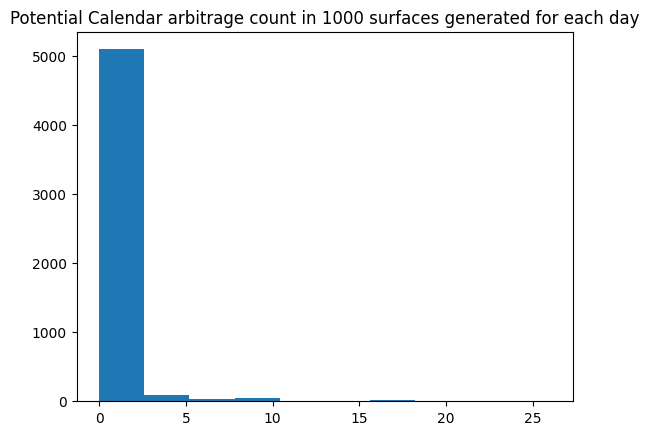

In [6]:
# find where the condition failed, and sum up for each surface
neg_dw_dt = np.where(dw_dt < 0, 1, 0)
non_cal_arbitrage_free = np.where(np.sum(np.sum(neg_dw_dt, axis=-1), axis=-1) > 2, 1, 0)
# This is a (num_day, num_sample) indicator array. 1 means that there is arbitrage opportunity
print(non_cal_arbitrage_free.shape)
non_cal_arbitarge_free_count_per_day = np.sum(non_cal_arbitrage_free, axis=1)
plt.hist(non_cal_arbitarge_free_count_per_day)
plt.title("Potential Calendar arbitrage count in 1000 surfaces generated for each day")
plt.show()

# Butterfly arbitrage
Here we want to make sure that $\left(1 - \frac{Xw'}{2w}\right)^2 - \frac{w'}{4} \left(\frac{1}{w} + \frac{1}{4}\right) + \frac{w''}{2}\geq 0$, where $w'=\frac{\partial w}{\partial X}$, $w''=\frac{\partial^2 w}{\partial X^2}$

In [7]:
moneyness_reshaped = moneyness.reshape((1, 1, 1, len(moneyness)))
butterfly = (1.0 - moneyness_reshaped * dw_dx / (2 * total_iv_surf)) ** 2 \
    - dw_dx / 4 * (1 / total_iv_surf + 1/4) \
    + dw_dx_sec / 2
print(butterfly.shape)

(5300, 1000, 5, 5)


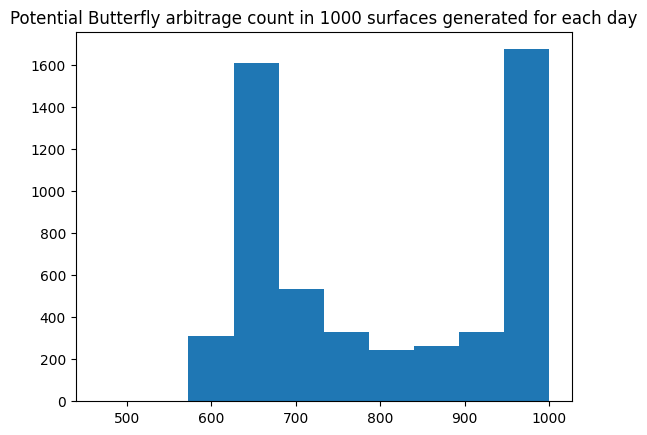

In [8]:
# find where the condition failed, and sum up for each surface
neg_butterfly_cal = np.where(butterfly < 0, 1, 0)
non_butterfly_arbitrage_free = np.where(np.sum(np.sum(neg_butterfly_cal, axis=-1), axis=-1) > 0, 1, 0)
# This is a (num_day, num_sample) indicator array. 1 means that there is arbitrage opportunity
non_butterfly_arbitrage_free_count_per_day = np.sum(non_butterfly_arbitrage_free, axis=1)
plt.hist(non_butterfly_arbitrage_free_count_per_day)
plt.title("Potential Butterfly arbitrage count in 1000 surfaces generated for each day")
plt.show()

# Real data

In [9]:
data = np.load("data/vol_surface_with_ret.npz")
vol_surf_data = data["surface"][3:5303]
ttm_reshaped = ttm.reshape((1, len(ttm), 1))
total_iv_surf_real = ttm_reshaped * vol_surf_data # w(ttm, K/S) = ttm * iv[ttm, K/S]

In [10]:
# gradient calculation
dw_dt_real = np.gradient(total_iv_surf_real, ttm, axis=-2, edge_order=2)
dw_dx_real = np.gradient(total_iv_surf_real, moneyness, axis=-1, edge_order=2)
dw_dx_sec_real = np.gradient(total_iv_surf_real, moneyness, axis=-1, edge_order=2)

In [11]:
# find where the condition failed, and sum up for each surface
neg_dw_dt_real = np.where(dw_dt < 0, 1, 0)
non_cal_arbitrage_free_real = np.where(np.sum(np.sum(neg_dw_dt_real, axis=-1), axis=-1) > 2, 1, 0)
# This is a (num_day, num_sample) indicator array. 1 means that there is arbitrage opportunity
print(non_cal_arbitrage_free_real.shape)

(5300, 1000)


In [12]:
moneyness_reshaped = moneyness.reshape((1, 1, len(moneyness)))
butterfly_real = (1.0 - moneyness_reshaped * dw_dx_real / (2 * (total_iv_surf_real+1e-8))) ** 2 \
    - dw_dx_real / 4 * (1 / (total_iv_surf_real+1e-8) + 1/4) \
    + dw_dx_sec_real / 2
print(butterfly_real.shape)

(5300, 5, 5)


In [13]:
# find where the condition failed, and sum up for each surface
neg_butterfly_real = np.where(butterfly_real < 0, 1, 0)
non_butterfly_arbitrage_free_real = np.where(np.sum(np.sum(neg_butterfly_real, axis=-1), axis=-1) > 4, 1, 0)
print(butterfly_real.shape)

(5300, 5, 5)


# compare

In [14]:
def compare_fn(real: Dict[str, np.ndarray], simulated: Dict[str, np.ndarray], ci=0.05):
    calendar_real = real["calendar"] # (num_day, 5, 5)
    butterfly_real = real["butterfly"] # (num_day, 5, 5)
    calendar_sim = simulated["calendar"] # (num_day, num_sim, 5, 5)
    butterfly_sim = simulated["butterfly"] # (num_day, num_sim, 5, 5)
    thres = ci*butterfly_sim.shape[1]

    # calendar
    calendar_df = pd.DataFrame(index=list(range(8)), columns=["real", "sim"])
    neg_cal_real = np.where(calendar_real < 0, 1, 0) # (num_day, 5, 5)
    neg_cal_sim = np.where(calendar_sim < 0, 1, 0) # (num_day, num_sim, 5, 5)

    for count in range(8):
        non_cal_arbitrage_free_real = np.where(np.sum(np.sum(neg_cal_real, axis=-1), axis=-1) > count, 1, 0) # (num_day,)
        calendar_df.loc[count, "real"] = np.sum(non_cal_arbitrage_free_real)

        non_cal_arbitrage_free_sim = np.where(np.sum(np.sum(neg_cal_sim, axis=-1), axis=-1) > count, 1, 0) # (num_day, num_sim)
        non_cal_arbitrage_free_sim = np.where(np.sum(non_cal_arbitrage_free_sim, axis=-1) > thres, 1, 0) # (num_day,)
        calendar_df.loc[count, "sim"] = np.sum(non_cal_arbitrage_free_sim) 

    # butterfly
    butterfly_df = pd.DataFrame(index=list(range(8)), columns=["real", "sim"])
    neg_but_real = np.where(butterfly_real < 0, 1, 0) # (num_day, 5, 5)
    neg_but_sim = np.where(butterfly_sim < 0, 1, 0) # (num_day, num_sim, 5, 5)

    for count in range(8):
        non_but_free_real = np.where(np.sum(np.sum(neg_but_real, axis=-1), axis=-1) > count, 1, 0) # (num_day,)
        butterfly_df.loc[count, "real"] = np.sum(non_but_free_real)

        non_but_free_sim = np.where(np.sum(np.sum(neg_but_sim, axis=-1), axis=-1) > count, 1, 0) # (num_day, num_sim)
        non_but_free_sim = np.where(np.sum(non_but_free_sim, axis=-1) > thres, 1, 0) # (num_day,)
        butterfly_df.loc[count, "sim"] = np.sum(non_but_free_sim)

    return {
        "calendar": calendar_df,
        "butterfly": butterfly_df
    }

In [15]:
real = {
    "calendar": dw_dt_real,
    "butterfly": butterfly_real,
}

sim = {
    "calendar": dw_dt,
    "butterfly": butterfly,
}
dfs = compare_fn(real, sim)

In [16]:
d = {}
d["Calendar"] = dfs["calendar"]
d["Butterfly"] = dfs["butterfly"]
count_df = pd.concat(d, axis=1)
count_df

Calendar       Butterfly      
      real   sim      real   sim
0     4022  4205      3859  5300
1     1257   447      1872  5293
2      271     0       536  1670
3       62     0       111   721
4       20     0        18   263
5        0     0         2     7
6        0     0         1     0
7        0     0         0     0

In [17]:
real = {
    "calendar": dw_dt_real,
    "butterfly": butterfly_real,
}

sim = {
    "calendar": dw_dt,
    "butterfly": butterfly,
}
dfs = compare_fn(real, sim, ci=0.1)

In [18]:
d = {}
d["Calendar"] = dfs["calendar"]
d["Butterfly"] = dfs["butterfly"]
count_df = pd.concat(d, axis=1)
count_df

Calendar       Butterfly      
      real   sim      real   sim
0     4022  4106      3859  5300
1     1257   248      1872  3921
2      271     0       536  1316
3       62     0       111   558
4       20     0        18   160
5        0     0         2     2
6        0     0         1     0
7        0     0         0     0